In [1]:
import os
import requests
import pandas as pd
import numpy as np
#from annotationframeworkclient import imagery
#from annotationframeworkclient.jsonservice import JSONService
#from annotationframeworkclient import imagery
import cloudvolume
from caveclient import CAVEclient
import nglui
from statistics import mean
import matplotlib.pyplot as plt

client = CAVEclient('minnie65_phase3_v1')
#client = CAVEclient('minnie65_public')
client.info.get_datastack_info()


{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1',
 'skeleton_source': 'precomputed://middleauth+https://minnie.microns-daf.com/skeletoncache/api/v1/minnie65_phase3_v1/precomputed/skeleton',
 'analysis_database': None,
 'viewer_site': 'https://neuroglancer.neuvue.io/',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_neuron_svm',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the first version of Minnie that has proofreading enabled. Was first enabled on June 24, 2020. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 

In [2]:
# MAIN
#'y' location of cortical surface
surface_y_column =[84534, 85689, 86053, 87800, 89421, 90105, 82884, 81677, 86242]
average_surface_location = mean(surface_y_column)

In [3]:
# MAIN
#IMPORT SYNAPSE TABLE

pd.options.display.max_rows = None
pd.options.display.max_columns = None

synapse_table = pd.read_feather("ET_Column_synapse_table_revision.feather")



In [4]:
# check duplicate entries 
duplicates = synapse_table[synapse_table['synapse_id'].duplicated(keep=False)]

print("Duplicate entries:")
print(duplicates.synapse_id.unique())

# Remove duplicate rows 

print("original synapse table size")
print(synapse_table.shape)

synapse_table = synapse_table.drop_duplicates(subset='synapse_id')

print(" synapse table size without duplicates")
print(synapse_table.shape)

Duplicate entries:
[140819175 137309229 162886969 182778049]
original synapse table size
(3834, 35)
 synapse table size without duplicates
(3814, 35)


In [35]:
#ANALYSIS - GENERAL

#NUMBER OF SYNAPSES

synapse_numbers = { 'total_synapses' : len(synapse_table),
                    
                    'synapses_with_class_labels' : len(synapse_table[pd.notna(synapse_table['consensus_class'])]),

                    'synapses_with_class_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_class'])) &
                                                                            (synapse_table['manual_class'] != 'unclear')]),

                    'synapses_with_class_labels_automated' : len(synapse_table[((pd.notna(synapse_table['NEURD_class'])) & (synapse_table['NEURD_class'] != "None") |
                      (pd.notna(synapse_table['metamodel_class'])) & (synapse_table['metamodel_class'] != "None"))]),

                    'synapses_without_class_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_class']))]),
                   
                    'synapses_with_subclass_labels' : len(synapse_table[pd.notna(synapse_table['consensus_subclass'])]),
                    
                    'synapses with_subclass_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_subclass'])) &
                                                                            (synapse_table['manual_subclass'] != 'excitatory') & 
                                                                            (synapse_table['manual_subclass'] != 'inhibitory')]),
                    
                    'synapses_without_subclass_labels' : len(synapse_table[pd.isna(synapse_table['consensus_subclass'])]),
                   
                    'synapses_with_orphans' : len(synapse_table[synapse_table['num_soma'] == 0]),
                                                 
                    'synapses_with_orphans_with_class_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.notna(synapse_table['consensus_class'])]),
                   
                    'synapses_with_orphans_without_class_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.isna(synapse_table['consensus_class'])]),
                   
                    'synapses_with_orphan_spines': len(synapse_table[synapse_table['orphan'] == 'single_spine']),
                   
                    'synapses_with_orphan_dendrites_without_class_labels': len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    (pd.isna(synapse_table['consensus_class'])) &
                                                                    (synapse_table['orphan'] == 'dendrite')]),
                   
                    'synapses_with_orphans_with_subclass_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.notna(synapse_table['consensus_subclass'])]),
                    'synapses_with_orphans_without_subclass_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.isna(synapse_table['consensus_subclass'])]),

                                   
                    'synapses_with_multisoma' : len(synapse_table[synapse_table['num_soma'] > 1]),
                    'synapses_with_multisoma_with_class_labels' : len(synapse_table[(synapse_table['num_soma'] > 1) &
                                                                    pd.notna(synapse_table['consensus_class'])]),
                    'synapses_with_multisoma_without_class_labels' : len(synapse_table[(synapse_table['num_soma'] > 1) &
                                                                    pd.isna(synapse_table['consensus_class'])]),
}


#NUMBER OF SOMATA

connection_numbers = {
                    'total_connections' : len(synapse_table[synapse_table['num_soma'] == 1].post_pt_root_id.unique()),
                   
                    'connections_with_class_labels' : len(synapse_table[pd.notna(synapse_table['consensus_class']) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
    
                    'connections_with_class_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_class'])) &
                                                             (synapse_table['manual_class'] != 'unclear') &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    
                    'connections_without_class_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_class'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                
                    'with_subclass_labels' : len(synapse_table[(pd.notna(synapse_table['consensus_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    'with_subclass_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    'without_subclass_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
   
}

connection_numbers, synapse_numbers

({'total_connections': 1431,
  'connections_with_class_labels': 1418,
  'connections_with_class_labels_manual': 541,
  'connections_without_class_labels': 13,
  'with_subclass_labels': 1407,
  'with_subclass_labels_manual': 236,
  'without_subclass_labels': 24},
 {'total_synapses': 3814,
  'synapses_with_class_labels': 3618,
  'synapses_with_class_labels_manual': 2465,
  'synapses_with_class_labels_automated': 3512,
  'synapses_without_class_labels': 196,
  'synapses_with_subclass_labels': 3534,
  'synapses with_subclass_labels_manual': 1583,
  'synapses_without_subclass_labels': 280,
  'synapses_with_orphans': 254,
  'synapses_with_orphans_with_class_labels': 75,
  'synapses_with_orphans_without_class_labels': 179,
  'synapses_with_orphan_spines': 130,
  'synapses_with_orphan_dendrites_without_class_labels': 47,
  'synapses_with_orphans_with_subclass_labels': 4,
  'synapses_with_orphans_without_subclass_labels': 250,
  'synapses_with_multisoma': 6,
  'synapses_with_multisoma_with_clas

In [40]:
#CREATE NEUROGLANCER LINK

#manual_check = synapse_table.iloc[3000:3833]

from nglui import statebuilder

img, seg = statebuilder.from_client(client)

pt_map = statebuilder.PointMapper('post_pt_position', linked_segmentation_column='post_pt_supervoxel_id')
anno = statebuilder.AnnotationLayerConfig('post_pt_position', mapping_rules=pt_map, linked_segmentation_layer=seg.name,
                                          tags=['spine', 'shaft', 'soma', 'soma_spine', 'orphan', 'other'])
sb = statebuilder.StateBuilder([img, seg, anno], client=client)

#here is where you add the dataframe
sb.render_state(manual_check[['post_pt_supervoxel_id','post_pt_position']], return_as='short', target_site = 'spelunker')

#[id, x,y,z]



'https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5977503257591808'

In [43]:
# MAIN

#Verify that neurons with consensus subclass have somata

synapse_table[(synapse_table['num_soma'] == 0) & pd.notna(synapse_table['consensus_subclass'])]

,synapse_id,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_mesh_ind_filt,dist_to_root,distance_rank,pre_nucleus_id,post_nucleus_id,post_soma_pt,NEURD_class,metamodel_class,metamodel_cell_type,mtypes_model_cell_type,mtypes_column,motif_group,post_soma_area,pre_soma_pt,pre_soma_area,manual_class_original,manual_subclass_original,num_soma,inhibitory_groups,manual_subclass,manual_class,consensus_class,consensus_subclass,orphan


In [42]:
# MAIN
#correct_number of soma
def correct_soma_number(row):
        
    if row['orphan'] == 'neuron_with_soma':
          return  {'num_soma': 1}    

    else:
          return row['num_soma']  

synapse_table['num_soma'] = synapse_table.apply(correct_soma_number, axis=1)



In [44]:
#ANALYSIS - FIGURE 2
#Number of synapses per ET neuron

client = CAVEclient('minnie65_phase3_v1')
client.info.get_datastack_info()

# setup an empty list
ds=[]

#Number of inputs and outputs for each ET neuron
pt_IDs = synapse_table.pre_pt_root_id.unique()

for pt_id in synapse_table.pre_pt_root_id.unique():

        print(pt_id)
        
        d={
                        'pt_soma_ID': pt_id,
                        'number_output_synapses': len(synapse_table[synapse_table['pre_pt_root_id'] == pt_id]),
                        'number_input_synapses': len(client.materialize.synapse_query(post_ids=pt_id)),
        }
        
        #append entry
        ds.append(d)

pt_io = pd.DataFrame(ds)
pt_io

864691136313000765
864691135866820485
864691136663371742
864691134941063523
864691135576602910
864691135503182685
864691135489514810
864691135498760723
864691134940999267
864691135214123064
864691136335150259
864691135911028905
864691135948123745
864691136437631902
864691135782220112
864691135716281370
864691135865557118
864691135777116589
864691136024995385
864691135591736587
864691135214122296
864691136991202453
864691135851941575
864691135585266808
864691136330101226
864691136362774498
864691135565831447
864691135276295653
864691135688186080
864691136228250961
864691135778738877
864691136419797655
864691136287648195
864691135517376211
864691135275560677
864691136039974142
864691137020891758
864691136444943747
864691136137794941


,pt_soma_ID,number_output_synapses,number_input_synapses
0,864691136313000765,95,5727
1,864691135866820485,98,0
2,864691136663371742,100,4503
3,864691134941063523,99,6338
4,864691135576602910,97,0
5,864691135503182685,99,11128
6,864691135489514810,98,26797
7,864691135498760723,96,8049
8,864691134940999267,97,0
9,864691135214123064,98,4640


In [45]:
#ANALYSIS - FIGURE 2
#MAKE STATS DATAFRAME - All synapses and connections

np.seterr(divide='ignore', invalid='ignore')

percentage = []
values = []

#IDs of presynaptic PT neurons
pre_soma_IDs = synapse_table['pre_nucleus_id'].unique()


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
   
    stat_values={

                    'ID': pre_soma_ID,
                    
        #SYNAPSES
                    
                    'all_syn_total': len(synapse_table[ (synapse_table['pre_nucleus_id'] == pre_soma_ID)]),
                    'all_e_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]),
                    'all_i_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]),        
                    'all_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]),
                    
        
                    'all_23P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]),
        
                    'all_4P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]),
                    'all_5P-PT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-PT')]),
                    'all_5P-NP_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]), 
                    'all_5P-IT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]), 
                
                    'all_6P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]),
        
                    'all_6P-CT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-CT')]),
        
                    'all_6P-IT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-IT')]),
        
                    'all_BC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]),
        
                    'all_MC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]),
        
                    'all_BPC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]),
        
                    'all_NGC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]),
        
                    'all_Undetermined_subclass_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]),
        
        
        #CONNECTIONS
                    'all_con_total': len(synapse_table[ (synapse_table['pre_nucleus_id'] == pre_soma_ID)]
                                         ['post_pt_root_id'].unique()),
                    
                    'all_e_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]
                                      ['post_pt_root_id'].unique()),
                    
                    'all_i_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]
                                      ['post_pt_root_id'].unique()),
        
                    'all_Undetermined_class_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]['post_pt_root_id'].unique()),                      
        
                    'all_23P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]['post_pt_root_id'].unique()),
        
                    'all_4P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]['post_pt_root_id'].unique()),
                    
                    'all_5P-PT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-PT')]['post_pt_root_id'].unique()),
                    
                    'all_5P-NP_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]['post_pt_root_id'].unique()), 
 
                    'all_5P-IT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_6P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]['post_pt_root_id'].unique()),
                
                    'all_6P-CT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-CT')]['post_pt_root_id'].unique()),
        
                    'all_6P-IT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_BC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]['post_pt_root_id'].unique()),
                     
                    'all_MC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]['post_pt_root_id'].unique()),
       
                    'all_BPC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]['post_pt_root_id'].unique()),
                    
                    'all_NGC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]['post_pt_root_id'].unique()),
        
                    'all_Undetermined_subclass_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]['post_pt_root_id'].unique()),
                        
        
    }
    values.append(stat_values)
    
    
    stat_percentage={

                    'ID': pre_soma_ID,
                    'Soma_depth':  (client.materialize.query_table('nucleus_detection_v0', 
                               filter_equal_dict={'id':pre_soma_ID})['pt_position'].apply(lambda x: x[1]).iloc[0]
                                                  - average_surface_location)*0.004,
                   
                      
                    'i_syn': stat_values['all_i_syn#'] / stat_values['all_syn_total'],
                    'e_syn': stat_values['all_e_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_class_syn': stat_values['all_Undetermined_class_syn#'] / stat_values['all_syn_total'],

        
                    'i_syn_determined': stat_values['all_i_syn#'] / (stat_values['all_i_syn#']+stat_values['all_e_syn#']),
                    'e_syn_determined': stat_values['all_e_syn#'] / (stat_values['all_i_syn#']+stat_values['all_e_syn#']),
        
        
                    '23P_syn': stat_values['all_23P_syn#'] / stat_values['all_syn_total'],
                    '4P_syn': stat_values['all_4P_syn#'] / stat_values['all_syn_total'],
                    '5P-PT_syn': stat_values['all_5P-PT_syn#'] / stat_values['all_syn_total'],
                    '5P-IT_syn': stat_values['all_5P-IT_syn#'] / stat_values['all_syn_total'],
                    '5P-NP_syn': stat_values['all_5P-NP_syn#'] / stat_values['all_syn_total'],
                    '6P_syn': stat_values['all_6P_syn#'] / stat_values['all_syn_total'],
                    '6P-IT_syn': stat_values['all_6P-IT_syn#'] / stat_values['all_syn_total'],
                    '6P-CT_syn': stat_values['all_6P-CT_syn#'] / stat_values['all_syn_total'],
                    'BC_syn': stat_values['all_BC_syn#'] / stat_values['all_syn_total'],
                    'MC_syn': stat_values['all_MC_syn#'] / stat_values['all_syn_total'],
                    'BPC_syn': stat_values['all_BPC_syn#'] / stat_values['all_syn_total'],
                    'NGC_syn': stat_values['all_NGC_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_subclass_syn': stat_values['all_Undetermined_subclass_syn#'] / stat_values['all_syn_total'],
        
        
                    'i_con': stat_values['all_i_con#'] / stat_values['all_con_total'],
                    'e_con': stat_values['all_e_con#'] / stat_values['all_con_total'],
                    'Undetermined_class_con': stat_values['all_Undetermined_class_con#'] / stat_values['all_con_total'],
                   
        
                    '23P_con': stat_values['all_23P_con#'] / stat_values['all_con_total'],
                    '4P_con': stat_values['all_4P_con#'] / stat_values['all_con_total'],
                    '5P-PT_con': stat_values['all_5P-PT_con#'] / stat_values['all_con_total'],
                    '5P-IT_con': stat_values['all_5P-IT_con#'] / stat_values['all_con_total'],
                    '5P-NP_con': stat_values['all_5P-NP_con#'] / stat_values['all_con_total'],
                    '6P_con': stat_values['all_6P_con#'] / stat_values['all_con_total'],
                    '6P-IT_con': stat_values['all_6P-IT_con#'] / stat_values['all_con_total'],
                    '6P-CT_con': stat_values['all_6P-CT_con#'] / stat_values['all_con_total'],
                    'BC_con': stat_values['all_BC_con#'] / stat_values['all_con_total'],
                    'MC_con': stat_values['all_MC_con#'] / stat_values['all_con_total'],
                    'BPC_con': stat_values['all_BPC_con#'] / stat_values['all_syn_total'],
                    'NGC_con': stat_values['all_NGC_con#'] / stat_values['all_con_total'],
                    'Undetermined_subclass_con': stat_values['all_Undetermined_subclass_con#'] / stat_values['all_con_total'],
                   
    }
    percentage.append(stat_percentage) 
    

synapse_table_values = pd.DataFrame(values)
synapse_table_percentage = pd.DataFrame(percentage)


#stats_type.append(stat)   


In [46]:
#synapse_table_percentage
synapse_table_values

,ID,all_syn_total,all_e_syn#,all_i_syn#,all_Undetermined_class_syn#,all_23P_syn#,all_4P_syn#,all_5P-PT_syn#,all_5P-NP_syn#,all_5P-IT_syn#,all_6P_syn#,all_6P-CT_syn#,all_6P-IT_syn#,all_BC_syn#,all_MC_syn#,all_BPC_syn#,all_NGC_syn#,all_Undetermined_subclass_syn#,all_con_total,all_e_con#,all_i_con#,all_Undetermined_class_con#,all_23P_con#,all_4P_con#,all_5P-PT_con#,all_5P-NP_con#,all_5P-IT_con#,all_6P_con#,all_6P-CT_con#,all_6P-IT_con#,all_BC_con#,all_MC_con#,all_BPC_con#,all_NGC_con#,all_Undetermined_subclass_con#
0,267008,95,24,63,8,0,0,0,0,6,11,0,0,25,37,1,0,8,60,24,28,8,0,0,0,0,6,11,0,0,12,15,1,0,8
1,267260,98,39,56,3,0,0,0,1,5,25,0,0,27,28,0,0,5,81,38,40,3,0,0,0,1,4,25,0,0,19,20,0,0,5
2,266848,100,27,69,4,1,0,0,0,6,14,0,0,33,36,0,0,4,74,25,45,4,1,0,0,0,6,14,0,0,19,26,0,0,4
3,267183,99,38,59,2,0,0,0,5,14,14,0,0,37,19,0,1,4,71,35,34,2,0,0,0,4,12,14,0,0,21,10,0,1,4
4,267185,97,55,38,4,0,1,0,3,15,22,0,0,16,17,2,2,9,87,54,29,4,0,1,0,3,14,22,0,0,12,13,2,1,9
5,267029,99,26,71,2,0,0,0,5,8,10,0,0,48,21,2,0,2,65,24,39,2,0,0,0,5,6,10,0,0,23,15,1,0,2
6,267033,98,20,76,2,0,0,0,5,5,10,0,0,52,18,0,2,6,64,19,43,2,0,0,0,4,5,10,0,0,25,14,0,1,5
7,267038,96,29,59,8,0,0,0,5,6,13,0,0,27,26,2,0,13,73,28,37,8,0,0,0,5,6,12,0,0,15,17,2,0,12
8,267194,97,23,71,3,0,0,0,7,7,5,0,0,46,24,1,0,3,62,20,39,3,0,0,0,4,7,5,0,0,22,16,1,0,3
9,267295,98,44,46,8,0,0,0,1,3,34,0,0,16,23,5,0,13,82,42,33,7,0,0,0,1,3,33,0,0,11,17,3,0,11


In [ ]:
#synapses versus connections


print('total number of synapses with I targets = ', synapse_table_values['all_i_syn#'].sum())

print('total number of connections with I targets = ', synapse_table_values['all_i_con#'].sum())

print('synapses per connection with I targets = ', synapse_table_values['all_i_syn#'].sum()/
      synapse_table_values['all_i_con#'].sum())

print('total number of synapses with E targets = ', synapse_table_values['all_e_syn#'].sum())

print('total number of connections with E targets = ', synapse_table_values['all_e_con#'].sum())

print('synapses per connection with E targets = ', synapse_table_values['all_e_syn#'].sum()/
      synapse_table_values['all_e_con#'].sum())

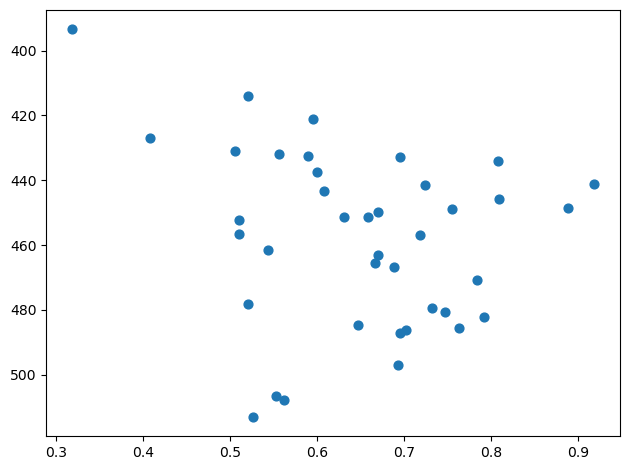

In [47]:
#ANALYSIS - FIGURE 2.c1
#percentage of inhibitory targets

# size and color:
sizes = 40


# plot
fig, ax = plt.subplots()

ax.scatter(synapse_table_percentage['i_syn_determined'].values, synapse_table_percentage['Soma_depth'].values, s=sizes) 
ax.invert_yaxis()
plt.tight_layout()

fig.savefig('Fig2c1_E_I_revision.eps', bbox_inches='tight')

plt.show()









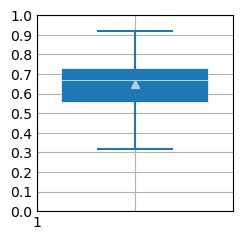

In [48]:
#ANALYSIS - FIGURE 2.c2
#boxplot


plt.style.use('_mpl-gallery')

# make data:
np.random.seed(10)
#D = np.random.normal((3, 5, 4))
D = synapse_table_percentage.i_syn_determined.values

# plot
fig, ax = plt.subplots()
VP = ax.boxplot(D,  widths=1.5, patch_artist=True,
                showmeans=True, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})


#ax.set_yticks()
ax.set(xlim=(0, 2), xticks=np.arange(0, 2),
       ylim=(0, 1), yticks=np.arange(0, 1.1 , 0.1))

fig.savefig('Fig2c2_E_I_box_revision.eps', bbox_inches='tight')

plt.show()

In [49]:
#ANALYSIS - FIGURE 2.d
# skeleton of inhibitory neuron

%load_ext autoreload
%autoreload 2
import skeleton_plot as skelplot
from skeleton_plot.skel_io import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import meshparty
%matplotlib inline


#raw skeleton files
skel_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'

# upright
upright_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/upright/BIL_excitatory/'

# layer aligned
layer_aligned_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/layer_align/BIL_excitatory/'


# polygon files (layer bounds for each cell)
# gives 2d shape for each layer 
layer_bounds_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/poly_files/BIL_polys/'

# average layer bounds from IVSCC (to which layer aligned celled are alligned)
# this just gives a single value for each layer (straight line)
#layer_bounds_average_path = "gs://allen-minnie-phase3/minniephase3-emily_skeleton_keys/avg_layer_depths/"
avg_layerdepths_filename = 'mouse_me_and_met_avg_layer_depths.json'


# mesh path with gs://
#mw_path = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'

# neuron IDs
rid = 864691135856066862
sid = 305046

# now https version 
depths = read_json('https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/avg_layer_depths/',
                                         avg_layerdepths_filename)
# plot the radius from the swc 

sk = read_skeleton(skel_path+f'{rid}_{sid}', f'{rid}_{sid}.swc')



fig, ax = plt.subplots(figsize=(7,10))
skelplot.plot_tools.plot_skel(sk,  ax=ax, pull_radius = True, pull_compartment_colors = True,
                              invert_y=True, plot_soma = True, 
                             line_width = 3, color = 'darkslategray') 


fig.savefig('basket_skel.eps')

ImportError: dlopen(/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so, 0x0002): tried: '/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (no such file), '/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

In [ ]:
#ANALYSIS - FIGURE 2.e
# connectivity plot
import tqdm
import pcg_skel
client = CAVEclient('minnie65_phase3_v1')
skeldir = 'skeletons'
now = client.materialize.get_timestamp()

neuron_df = client.materialize.query_table(
    "nucleus_detection_v0", filter_equal_dict={"id": 305046})

# Build the skeletons
nrns = {}

for _, row in tqdm.tqdm(neuron_df.iterrows()):

    #print(row)
    if os.path.exists(f"{skeldir}/{row['pt_root_id']}.h5"):
        nrns[row["pt_root_id"]] = meshwork.load_meshwork(f"{skeldir}/{row['pt_root_id']}.h5")
   
    else:
    
        nrns[row["pt_root_id"]] = pcg_skel.coord_space_meshwork(
            row["pt_root_id"],
            client=client,
            root_point=row["pt_position"],
            root_point_resolution=[4, 4, 40],
            collapse_soma=True,
            synapses="all",
            synapse_table=client.info.get_datastack_info().get("synapse_table"),
            timestamp = now,
        )

        nrns[row["pt_root_id"]].save_meshwork(f"{skeldir}/{row['pt_root_id']}.h5")        
        
# Get the axons
for rid, nrn in nrns.items():
    is_axon = meshwork.algorithms.split_axon_by_annotation(
        nrn,
        'pre_syn',
        'post_syn',
        return_quality=False
    )
    nrn.anno.add_annotations('is_axon', is_axon, mask=True)
    
pre_df = []
for rid in neuron_df["pt_root_id"]:
    syn_filt = nrns[rid].anno.pre_syn.filter_query(
            nrns[rid].anno.is_axon.mesh_mask
    )
    df = syn_filt.df
    df['dist_to_root'] = nrns[rid].distance_to_root(syn_filt.mesh_index)
    df['distance_rank'] = df['dist_to_root'].rank()
    df.attrs = {}
    pre_df.append(df)
    
neuron_pre_df= pd.concat(pre_df, ignore_index=True)
neuron_pre_df['pre_pt_root_id'] = client.chunkedgraph.get_roots(neuron_pre_df['pre_pt_supervoxel_id'], timestamp=now)
neuron_pre_df['post_pt_root_id'] = client.chunkedgraph.get_roots(neuron_pre_df['post_pt_supervoxel_id'], timestamp=now).astype('int')
        

# Get single soma root ids and add cell types

soma_df = client.materialize.query_table(
    "nucleus_neuron_svm", filter_equal_dict={"cell_type": "neuron"}
)

soma_df = soma_df.drop_duplicates(subset="pt_root_id", keep='first')

mtypes_model_df = client.materialize.query_table(
    "aibs_metamodel_mtypes_v661_v2",
).drop_duplicates('pt_root_id', keep=False)

# Enrich soma_df with all this info
soma_df = (
    soma_df.merge(        
        mtypes_model_df[["pt_root_id", "cell_type"]].rename(
            columns={"cell_type": "model_cell_type"}
        ),
        on="pt_root_id",
        how="left",
    )
)


#Add subclass labels to soma_df
def standardize_subclass(row):
        
        
    if row['model_cell_type'] == 'L3b':
          return 'L23P'

    if row['model_cell_type'] == 'MC':
          return 'DTC'
    
    if row['model_cell_type'] == 'BC':
          return 'PTC'
    
    if row['model_cell_type'] == 'BPC':
          return 'ITC'
    
    if row['model_cell_type'] == 'NGC':
          return 'STC'
            
    if row['model_cell_type'] == '23P':
          return 'L23P'
            
    if row['model_cell_type'] == 'L2b':
          return 'L23P'
          
    if row['model_cell_type'] == 'L6tall-c':
          return 'L6P'
          
    if row['model_cell_type'] == 'L6short-b':
          return 'L6P'
          
    if row['model_cell_type'] == 'L4b':
          return 'L4P'
          
    if row['model_cell_type'] == 'L2a':
          return 'L23P'
   
    if row['model_cell_type'] == 'L3a':
          return 'L23P'
          
    if row['model_cell_type'] == 'L6tall-b':
          return 'L6P'
          
    if row['model_cell_type'] == 'L2c':
          return 'L23P'
          
    if row['model_cell_type'] == 'L4a':
          return 'L4P'

    if row['model_cell_type'] == '4P':
          return 'L4P'
        
    if row['model_cell_type'] == 'L6wm':
          return 'L6P'
        
    if row['model_cell_type'] == 'L6tall-a':
          return 'L6P'
 
    if row['model_cell_type'] == 'L6short-a':
          return 'L6P'
          
    if row['model_cell_type'] == 'L5a':
          return 'L5IT'
        
    if row['model_cell_type'] == 'L5b':
          return 'L5IT'
        
    if row['model_cell_type'] == 'L4c':
          return 'L4P'
  
    if row['model_cell_type'] == 'none':
          return None
               
    if pd.isna(row['model_cell_type']) == True:
          return None
        
    else:
          return row['model_cell_type'] 

soma_df['model_subclass'] = soma_df.apply(standardize_subclass, axis=1)


#Merge all this info from cell types into the synapse dataframe, as well as add area locations.

#merge presynaptic nucleous ID
synapse_table_305046 = neuron_pre_df.merge(
    soma_df[
        ["id", "pt_root_id", "pt_position", "model_subclass"]
    ].rename(columns={"pt_position": "post_soma_pt"}).rename(columns={"id": "post_nucleus_id"}),
    left_on="post_pt_root_id",
    right_on="pt_root_id",
    how="left",
).drop(columns="pt_root_id")

synapse_table_305046 = synapse_table_305046.rename(columns={"id": "synapse_id"})
    
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,8))

ax = sns.histplot(data=synapse_table_305046, y="model_subclass",shrink=.8,)

plt.savefig('fig2_7_hist.eps')
    

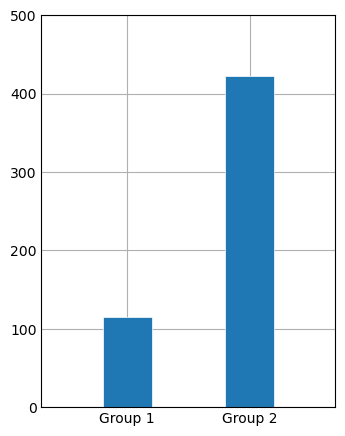

In [50]:
#ANALYSIS - FIGURE 2.g
#percentage of Inhibitory group 2 targets


#number of synapses with Inhibitory group 1 targets
group1 = len(synapse_table[(synapse_table['inhibitory_groups'] ==  1)])

#number of synapses with Inhibitory group 2 targets
group2 = len(synapse_table[(synapse_table['inhibitory_groups'] ==  2)])


import matplotlib.pyplot as plt
import numpy as np
plt.style.use('_mpl-gallery')

# make data:
np.random.seed(3)
x = ['Group 1', 'Group 2']
y = [group1, group2]

# plot
fig, ax = plt.subplots(figsize = (3,4))

ax.bar(x, y, width=0.4, edgecolor="white", linewidth=0.5, align='center')

# Add empty space on the edges
ax.set_xlim(-0.7, 1.7)

# Set y-axis ticks at increments of 100
max_y = max(y)
ax.set_yticks(np.arange(0, max_y + 100, 100))


#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

fig.savefig('Fig2g_inhibitory_groups_input_revision.eps', bbox_inches='tight')

plt.show()


